In [1]:
import sys
sys.path.append("models/raster")
sys.path.append("models/vector")
sys.path.append("models/multimodal")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from auxiliary.visualization import visualize_losses, visualize_multiple_losses
from auxiliary.misc import send_notification, get_model_name

from initialize_raster import load_trained_raster_model

from initialize_vector import load_trained_vector_model
from dataset_vector import get_dummy_sample
from features import important_features

from initialize_multimodal import get_constituent_model_filenames
from dataset_multimodal import BuildingMultimodalDataset
from model_multimodal import MultimodalModel
from train_multimodal import train_multimodal_model

from models.operators import elimination_operators, selection_operators

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
    vector_path = "../scratch/vector"
    multimodal_path = "../scratch/multimodal"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"
    vector_path = "../data.nosync/vector"
    multimodal_path = "../data.nosync/multimodal"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

In [5]:
def load_training_validation_multimodal_dataset(operator_model, operators_to_predict, features, attach_roads, subset):
    '''Loads the training and validation dataset for the given model.'''
    # define path to training and validation data
    path_to_raster_training_data = os.path.join(raster_path, "training_data", operator_model, "training")
    path_to_vector_training_data = os.path.join(vector_path, "training_data", operator_model, "training")
    path_to_raster_validation_data = os.path.join(raster_path, "training_data", operator_model, "validation")
    path_to_vector_validation_data = os.path.join(vector_path, "training_data", operator_model, "validation")

    # construct training Dataset
    training_set = BuildingMultimodalDataset(path_to_raster_training_data, 
                                             path_to_vector_training_data, 
                                             operators=operators_to_predict,
                                             features=features,
                                             attach_roads=attach_roads,
                                             raster_transform=None,
                                             vector_transform=None,
                                             subset=subset)
    
    # construct validation Dataset (no shuffling)
    validation_set = BuildingMultimodalDataset(path_to_raster_validation_data, 
                                               path_to_vector_validation_data, 
                                               operators=operators_to_predict,
                                               features=features,
                                               attach_roads=attach_roads,
                                               raster_transform=None,
                                               vector_transform=None,
                                               subset=subset)

    return training_set, validation_set

def conduct_multimodal_model_training(architecture, operator_model, attach_roads, n_epochs, batch_size, device, subset=None):
    '''Given an architecture, model and further parameters, conducts a full training routine of the multimodal model.
    The loss history and the model are saved to disk.'''
    assert operator_model in ("elimination", "selection")
    operators_to_predict = elimination_operators if operator_model == "elimination" else selection_operators

    # extract individual architectures
    architecture_raster, architecture_vector = architecture.split("+")[0], architecture.split("+")[1]
    assert architecture_raster in ("cnn", "vit")
    assert architecture_vector in ("hgnn", "hgt")

    # get the filenames of the trained constituent models
    raster_model_filename, vector_model_filename = get_constituent_model_filenames(architecture, operator_model, attach_roads)

    # define important features
    features = important_features[f"{architecture_vector.upper()} {operator_model}"]

    # load training and validation data
    training_set, validation_set = load_training_validation_multimodal_dataset(operator_model=operator_model, 
                                                                               operators_to_predict=operators_to_predict, 
                                                                               features=features, 
                                                                               attach_roads=attach_roads, 
                                                                               subset=subset)
    print(f"{len(training_set):,} samples in the training set.")
    print(f"{len(validation_set):,} samples in the validation set.")
                
    # load the trained raster model
    raster_model = load_trained_raster_model(raster_model_filename, raster_path, device)

    # load trained vector model
    vector_model = load_trained_vector_model(vector_model_filename, vector_path, device)

    # load dummy sample
    dummy_sample_path = os.path.join(vector_path, "training_data", "dummy_sample.pt")
    dummy_sample = get_dummy_sample(dummy_sample_path, 
                                    operators=operators_to_predict, 
                                    features=features, 
                                    attach_roads=attach_roads)

    # initialize multimodal model
    model = MultimodalModel(raster_model=raster_model, 
                            vector_model=vector_model, 
                            dummy_raster_sample=training_set[0][0], 
                            dummy_vector_sample=dummy_sample, 
                            n_classes=len(operators_to_predict))

    model.to(device)
    print(f"Using {model}")

    # get loss function and optimizer
    learning_rate = 0.0005
    criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # training the model
    model, training_losses, validation_losses, training_time = train_multimodal_model(model=model, 
                                                                                      device=device, 
                                                                                      optimizer=optimizer, 
                                                                                      criterion=criterion, 
                                                                                      n_epochs=n_epochs, 
                                                                                      batch_size=batch_size, 
                                                                                      validate=True, 
                                                                                      training_set=training_set, 
                                                                                      validation_set=validation_set, 
                                                                                      shuffle_training_set=True, 
                                                                                      shuffle_validation_set=False)
    
    # get a unique model name
    model_name = get_model_name(model, ops=operator_model[:3], attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, 
                                batch_size=batch_size, device=device)
    
    # saving the losses
    model_name_csv = model_name + ".csv"
    losses_path = os.path.join(multimodal_path, "model_outputs", operator_model, "losses", model_name_csv)
    
    # creating a DataFrame with loss values
    losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                              "training_loss": training_losses, 
                              "validation_loss": validation_losses})
    
    # save to CSV
    losses_df.to_csv(losses_path, index=False)
    
    # if working on ScienceCluster, send notification that training has finished
    if torch.cuda.is_available():
        send_notification(model=model, 
                          email_address="joris.senn@uzh.ch", 
                          n_samples=len(training_set), 
                          n_epochs=n_epochs, 
                          batch_size=batch_size, 
                          time=training_time)
    
    # save the trained model to disk
    path_to_models = os.path.join(multimodal_path, "models", operator_model)
    model_name_pth = model_name + ".pth"
    torch.save({"epoch": n_epochs,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": criterion,
                }, os.path.join(path_to_models, model_name_pth))

    loss_path = os.path.join(multimodal_path, "model_outputs", operator_model, "losses")
    visualize_losses(model_name_csv, loss_path)

## Elimination model

In [6]:
# architecture: CNN + HGNN, CNN + HGT, ViT + HGNN, ViT + HGT
architecture = "cnn+hgnn"
# define whether roads should be attached
attach_roads = True
# number of epochs
n_epochs = 2
# batch size to use for training
batch_size = 16

assert architecture in ("cnn+hgnn", "cnn+hgt", "vit+hgnn", "vit+hgt")

1,000 samples in the training set.
1,000 samples in the validation set.
Raster model successfully loaded.
Number of node features: {'focal_building': 2, 'context_building': 2, 'road': 2}, 1 operators
Vector model successfully loaded.
Using Multimodal Model with 4,556,993 parameters consisting of
        raster model (CNN) with 2,469,696 parameters and 
        vector model (HGNN) with 465,024 parameters.
epoch 1/2, step 6/63
epoch 1/2, step 12/63
epoch 1/2, step 18/63
epoch 1/2, step 24/63
epoch 1/2, step 30/63
epoch 1/2, step 36/63
epoch 1/2, step 42/63
epoch 1/2, step 48/63
epoch 1/2, step 54/63
epoch 1/2, step 60/63
epoch 1 finished, training loss: 0.632, validation loss: 0.601
epoch 2/2, step 6/63
epoch 2/2, step 12/63
epoch 2/2, step 18/63
epoch 2/2, step 24/63
epoch 2/2, step 30/63
epoch 2/2, step 36/63
epoch 2/2, step 42/63
epoch 2/2, step 48/63
epoch 2/2, step 54/63
epoch 2/2, step 60/63
epoch 2 finished, training loss: 0.544, validation loss: 0.606
Training time: 54.168 second

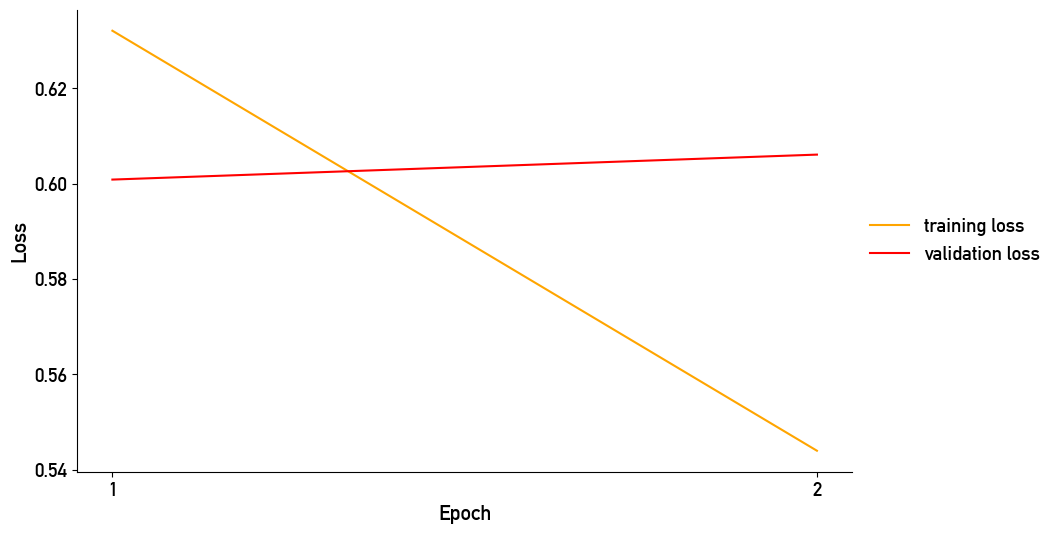

In [7]:
# conduct multimodal model training according to specifications
conduct_multimodal_model_training(architecture=architecture, 
                                  operator_model="elimination", 
                                  attach_roads=attach_roads, 
                                  n_epochs=n_epochs, 
                                  batch_size=batch_size, 
                                  device=device, 
                                  subset=1000)

## Multi-operator model

In [8]:
# architecture: CNN + HGNN, CNN + HGT, ViT + HGNN, ViT + HGT
architecture = "vit+hgnn"
# define whether roads should be attached
attach_roads = True
# number of epochs
n_epochs = 2
# batch size to use for training
batch_size = 16

assert architecture in ("cnn+hgnn", "cnn+hgt", "vit+hgnn", "vit+hgt")

1,000 samples in the training set.
1,000 samples in the validation set.
Raster model successfully loaded.
Number of node features: {'focal_building': 9, 'context_building': 9, 'road': 2}, 4 operators
Vector model successfully loaded.
Using Multimodal Model with 21,323,140 parameters consisting of
        raster model (ViT) with 20,520,448 parameters and 
        vector model (HGNN) with 473,984 parameters.
epoch 1/2, step 6/63
epoch 1/2, step 12/63
epoch 1/2, step 18/63
epoch 1/2, step 24/63
epoch 1/2, step 30/63
epoch 1/2, step 36/63
epoch 1/2, step 42/63
epoch 1/2, step 48/63
epoch 1/2, step 54/63
epoch 1/2, step 60/63
epoch 1 finished, training loss: 0.542, validation loss: 0.476
epoch 2/2, step 6/63
epoch 2/2, step 12/63
epoch 2/2, step 18/63
epoch 2/2, step 24/63
epoch 2/2, step 30/63
epoch 2/2, step 36/63
epoch 2/2, step 42/63
epoch 2/2, step 48/63
epoch 2/2, step 54/63
epoch 2/2, step 60/63
epoch 2 finished, training loss: 0.459, validation loss: 0.468
Training time: 22.536 seco

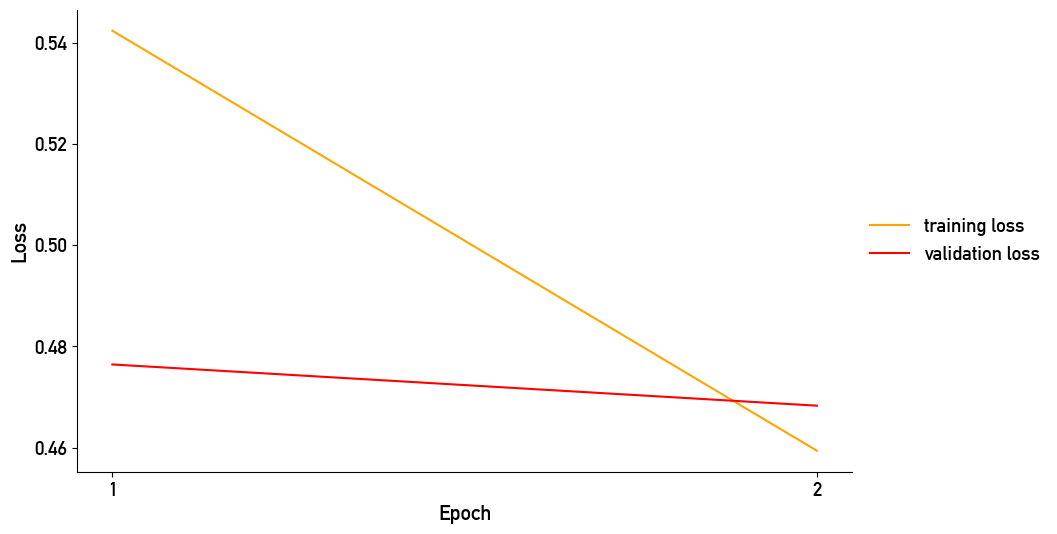

In [9]:
# conduct multimodal model training according to specifications
conduct_multimodal_model_training(architecture=architecture, 
                                  operator_model="selection", 
                                  attach_roads=attach_roads, 
                                  n_epochs=n_epochs, 
                                  batch_size=batch_size, 
                                  device=device, 
                                  subset=1000)

## Loss curves of multimodal models

In [ ]:
# loss path
model_losses = []

visualize_multiple_losses(model_losses, 
                          path_to_data="../data.nosync", 
                          model="multimodal", 
                          figsize=(6,5), 
                          save=True, 
                          output_path="../../Figures/Results/losses")